In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/DSL22_2/정규세션/0823 CNN

/content/drive/MyDrive/DSL22_2/정규세션/0823 CNN


# 1. 폴더 정리

* 제공해드린 animals10.zip의 압축을 풀어 그 내용을 살펴보시고, 폴더 구조를 학습에 알맞도록 재구성해주세요
* 특히 각 클래스마다 약 30% 정도의 이미지를 test 폴더에 할당해주세요
* 중간중간 헷갈리다면 이것저것 확인하는 코드를 거쳐보세요 (ex. flat_test[:5]로 앞의 다섯값 확인)
* 궁금한 점이 있을 경우, 슬랙 질문 채널 활용을 적극 권장합니다.

In [ ]:
### Guideline for convenience ###
# 압축 풀기|

!unzip -qq '/content/drive/MyDrive/DSL22_2/정규세션/0823 CNN/animals10.zip'

In [ ]:
# 각 클래스별 파일 개수 확인 -> 변수로 해당 개수 저장
# Tip) 클래스가 10개이므로 각 클래스마다 똑같은 내용의 코드를 계속 써야할까요? 클래스 이름을 리스트로 저장해 for문을 돌리면서 코드를 재사용하는건 어떨까요?

import os
import glob
import shutil

In [ ]:
os.chdir('./Animals-10')

In [ ]:
!ls

butterfly  cat	chicken  cow  dog  elephant  horse  sheep  spider  squirrel


In [ ]:
dir_list = os.listdir()

In [ ]:
dataset = {}
for dir in dir_list:
  os.chdir('./'+dir)
  dataset[dir]  = glob.glob('*.jpg') + glob.glob('*.jpeg')
  os.chdir('..')

In [ ]:
data_num={}
for key  in (dataset):
  print(key , ': ', len(dataset[key]))
  data_num[key] = len(dataset[key])

butterfly :  2072
cat :  1667
chicken :  3098
cow :  1866
dog :  4863
elephant :  1438
horse :  2623
sheep :  1820
spider :  4819
squirrel :  1862


In [ ]:
# test에 넣을 이미지 개수 계산

In [ ]:
int(sum(list(data_num.values())) * 0.2)

5225

In [ ]:
# train, test 폴더 경로 선언 & 만들기

In [ ]:
dir_list

['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'sheep',
 'spider',
 'squirrel',
 'train',
 'test']

In [ ]:
# 폴더 생성
for cl in dir_list:
  # train
  os.makedirs(os.path.join('./train',cl))
  # test
  os.makedirs(os.path.join('./test',cl))

In [ ]:
# train, test 폴더로 이미지 split해서 알맞게 집어넣기

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
dataset_path = '/content/drive/MyDrive/DSL22_2/정규세션/0823 CNN/Animals-10'

In [ ]:
for key, data in dataset.items():  
  x_train, x_test = train_test_split(data,test_size = 0.2, shuffle =True, random_state = 11)
  # train
  for x in x_train:
    shutil.copy(os.path.join(dataset_path,key,x),os.path.join(dataset_path, 'train',key,x))
  # test
  for x in x_test:
    shutil.copy(os.path.join(dataset_path,key,x),os.path.join(dataset_path, 'test',key,x))  


# 2. CNN 모델
수업 코드에 '모델 성능에 대한 고민!!' 부분을 참고해서 **test 이미지 기준 최소 80% 이상**의 모델이 나올 수 있도록 학습을 진행해주세요.
* 중간중간 헷갈리다면 이것저것 확인하는 코드를 거쳐보세요
* 90% 이상의 모델이 이상적이긴 합니다
* 궁금한 점이 있을 경우, 슬랙 질문 채널 활용을 적극 권장합니다.

전반적으로 수업 코드와 비슷하게 짜면 되는데, 생각해봐야 할 것은
* 모든 이미지를 내가 정의하는 하나의 모델에 넣어야함
* 그말은 input 데이터의 차원이 항상 동일해야 된다는 말
* 그런데 과연 내가 가지고 있는 이미지들의 사이즈가 모두 같을까? - 대략 얼마정도 사이즈 가지고 있는지 코드로 확인해보면 더 좋음 (shape 확인)
* 이미지 사이즈를 통일시키기 위해서는 어떻게 해야할까? - transforms의 Resize, RandomCrop 써볼까?
* 동물 이미지에 적합한 Augmentation은 무엇이 있을까?

In [3]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [4]:
dataset_path = '/content/drive/MyDrive/DSL22_2/정규세션/0823 CNN/Animals-10'

In [45]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [9]:
# ImageFolder와 앞서 정의한 transforms function을 활용해 Dataset 객체 (train, test에 대해) 선언

## dataset 삽질

In [ ]:
# train, test 이미지를 위한 transforms function 정의
# 위에서 말한 포인트들 생각해보기 - 차원에 유의하자!
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100,100))
])

In [15]:
class mydataset(Dataset):
  def __init__(self,dir, tf ):
    self.dir = dir
    self.tf = tf

    files = {}
    dataset = {}

    folders = os.listdir(dir)   
    for f in folders:
      files[f] = os.listdir(os.path.join(dir,f))

    y = []
    i = 0
    for c, names in files.items():
      print(c, ': ', len(names))
      for name in names:
        try:
          if i == 0:
            x = tf(Image.open(os.path.join(dir,c,name))).unsqueeze(0)
          else:
            x = torch.cat((x,tf(Image.open(os.path.join(dir,c,name))).unsqueeze(0)), axis =0)
          y.append(c)
          i += 1
          if i % 100 ==0: print(i)
        except:
          print('file error')

    self.x = x
    self.y = y
  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]


In [ ]:
trainset = mydataset(dataset_path + '/train', transformer)

KeyboardInterrupt: ignored

In [ ]:
testset = mydataset(dataset_path + '/test', transformer)

In [ ]:
to_int = {
    'butterfly':0,
    'cat':1,
    'chicken':2,
    'cow':3,
    'dog':4,
    'elephant':5,
    'horse': 6,
    'sheep': 7,
    'spider': 8,
    'squirrel': 9
}

In [ ]:
y = []
for target in trainset.y:
  y.append(to_int[target])
trainset.y = y

In [ ]:
y = []
for target in testset.y:
  y.append(to_int[target])
testset.y = y

In [ ]:
torch.save(trainset,'trainset.pt')

In [ ]:
torch.save(testset,'testset.pt')

In [ ]:
# train, test에 대해 DataLoader 정의

In [ ]:
device = torch.device( 'cuda:0'if torch.cuda.is_available else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
trainset = torch.load(dataset_path + "/trainset.pt",map_location = device)
testset = torch.load(dataset_path + "/testset.pt",map_location = device)

In [ ]:
train_loader = DataLoader(
    trainset,
    batch_size = 64,
    shuffle = True
)  
test_loader = DataLoader(
    testset,
    batch_size = 64,
    shuffle = False
)  


In [42]:
trainset.x.std(dim=(0,2,3))

tensor([0.2685, 0.2635, 0.2810], device='cuda:0')

In [37]:
trainset.x.mean(dim =(0,2,3) )

tensor([0.5180, 0.5003, 0.4125], device='cuda:0')

## Dataset

In [46]:
# train, test 이미지를 위한 transforms function 정의
# 위에서 말한 포인트들 생각해보기 - 차원에 유의하자!
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100,100)),
    transforms.Normalize((0.5180, 0.5003, 0.4125),(0.2685, 0.2635, 0.2810))
])

In [47]:
train_data = torchvision.datasets.ImageFolder(
    root = dataset_path + '/train',
    transform = transformer
)

test_data = torchvision.datasets.ImageFolder(
    root = dataset_path +'/test',
    transform = transformer
)

In [54]:
train_loader = DataLoader(train_data,batch_size = 64, shuffle =True)
test_loader = DataLoader(test_data,batch_size = 64, shuffle = False)

## Modeling

In [ ]:
### Model 클래스 정의 - 차원에 유의하자!
# 10개의 클래스를 분류해야 하는 꽤나 복잡한 task - 모델 구조를 어느 정도로 복잡하게 짜볼까?
# 가장 마지막 Linear의 out_features는 얼마로 해야할까?

In [48]:
import torch.nn as nn

In [51]:
class myCNN(nn.Module):
  def __init__(self):
    super(myCNN, self).__init__()

    self.layer = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 128,kernel_size = 3 ,padding = 1), #   3, 100, 100 -> 64, 100,100
        nn.ReLU(), 
        nn.Conv2d(in_channels = 128, out_channels = 128,kernel_size = 3 ,padding = 1), #
        nn.ReLU(),


        nn.MaxPool2d(kernel_size = 2, stride = 2) ,
        nn.Conv2d(in_channels =128 , out_channels = 256,kernel_size = 3 ,padding = 1), #   50x50
        nn.ReLU(),
        nn.Dropout(0.1),
        
        nn.Conv2d(in_channels = 256, out_channels = 256,kernel_size = 3 ,padding = 1), #   
        nn.ReLU(),

        # 모델이 너무 복잡해도 안되네요...
        nn.Dropout(0.1),
        
        nn.MaxPool2d(kernel_size = 2, stride = 2),

        nn.Conv2d(in_channels = 256, out_channels = 512,kernel_size = 3 ,padding = 1), #   25x25
        nn.ReLU(),

        
        nn.Conv2d(in_channels = 512, out_channels = 512,kernel_size = 3 ,padding = 1), #   25x25
        nn.ReLU(),
        # nn.Conv2d(in_channels = 512, out_channels = 512,kernel_size = 3 ,padding = 1), #   25x25
        # nn.ReLU(),
        
        # nn.Conv2d(in_channels = 512, out_channels = 1024,kernel_size = 3 ,padding = 1), #   25x25
        # nn.ReLU()      
    )
    self.fc_layer = nn.Sequential(
        nn.Linear(512*25*25, 50),
        nn.ReLU(),
        nn.Linear(50,10)  
    )
        
  def forward(self,x):
    out = self.layer(x)
    out = out.view(out.size(0),-1)
    out = self.fc_layer(out)
    return out



In [ ]:
# torchsummary로 모델 차원 어떻게 나오는지 돌려보기

In [52]:
from torchsummary import summary

In [53]:
testm = myCNN().to(device)
summary(testm, (3,100,100),batch_size =32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [32, 128, 100, 100]           3,584
              ReLU-2        [32, 128, 100, 100]               0
            Conv2d-3        [32, 128, 100, 100]         147,584
              ReLU-4        [32, 128, 100, 100]               0
         MaxPool2d-5          [32, 128, 50, 50]               0
            Conv2d-6          [32, 256, 50, 50]         295,168
              ReLU-7          [32, 256, 50, 50]               0
           Dropout-8          [32, 256, 50, 50]               0
            Conv2d-9          [32, 256, 50, 50]         590,080
             ReLU-10          [32, 256, 50, 50]               0
          Dropout-11          [32, 256, 50, 50]               0
        MaxPool2d-12          [32, 256, 25, 25]               0
           Conv2d-13          [32, 512, 25, 25]       1,180,160
             ReLU-14          [32, 512,

In [ ]:
# Device 선언 (GPU 권장)

In [11]:
device = torch.device( 'cuda:0'if torch.cuda.is_available else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
# 모델 객체 선언

In [57]:
mymodel = myCNN().to(device)

In [58]:
# loss func, optimizer 정의

In [59]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(mymodel.parameters(),lr = 0.001, weight_decay = 0.0001)

In [60]:
# train 함수 정의

In [61]:
def train(model, dataloader, batches):
  model.train()
  running_loss = 0.0
  batch_losses = []

  i = 0
  epoch = 1
  while True:

    total = 0
    correct = 0
    print('epoch :', epoch)
    
    for j,(x,y_true) in enumerate(dataloader):
      x, y_true = x.to(device), y_true.to(device)
      optimizer.zero_grad()
    
      y_pred = model(x)
      loss = criterion(y_pred, y_true)

      loss.backward()
      optimizer.step()

      total += y_true.size(0) # batch의 데이터개수
      running_loss += loss.item()
      batch_losses.append(loss.item())

      _, predicted_idx = y_pred.max(1)
      correct += (predicted_idx == y_true).sum().item() 

      if i % 50 == 49:
        print(f'\nCurrent batch: {str(i+1)}')
        print(f'Average train loss of recent 50 batches: {running_loss / 50}') # 이렇게 출력하는 것이 꼭 필요한 것은 아니지만, 중간중간 확인을 위해 매우 권장
        running_loss = 0.0

      i += 1
      epoch += 1
      if i>= batches: break

    avg_loss = sum(batch_losses) / len(batch_losses)
    train_loss.append(avg_loss)
    train_acc.append(100*correct/total)
    print('\nTotal train accuarcy:', 100. * correct / total) # 전체 데이터 개수에서 맞게 예측한 비율
    print('Total train loss:', avg_loss)
    test(model,test_loader)


    if i >= batches: break   





In [ ]:
# test 함수 정의

In [62]:
def test(model, data_loader):
  model.eval()
  loss = 0
  batch_losses = []
  correct = 0
  total = 0

  with torch.no_grad(): # gradient update 안함 - eval과 torch.no_grad는 하나의 세트
      for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        batch_losses.append(loss.item())

        total += targets.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == targets).sum().item()

  avg_loss = sum(batch_losses) / len(batch_losses)
  test_loss.append(avg_loss)
  test_acc.append(100 * correct / total)
  print('\nTest accuarcy:', 100. * correct / total)
  print('Test average loss:', avg_loss)
  # return avg_loss, (100 * correct/total)

In [63]:
# training

In [64]:
# 추후 시각화를 위해 매 epoch마다 loss, accuracy 값을 저장할 리스트
train_loss = []
test_loss = []
train_acc = []
test_acc = []

In [65]:
train(mymodel,train_loader,10000)

epoch : 1


KeyboardInterrupt: ignored

In [ ]:
test(mymodel,test_loader)


Test accuarcy: 52.619502868068835
Test average loss: 4.596361855181252


In [ ]:
# loss, accuracy 추이 확인 with plt.plot

In [ ]:
import matplotlib.pyplot as plt

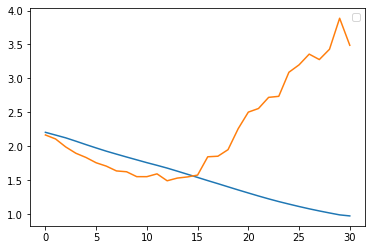

In [ ]:
## over fitting!
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend()

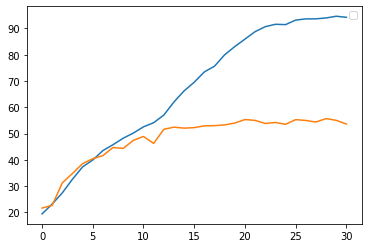

In [ ]:
plt.plot(train_acc)
plt.plot(test_acc)
plt.legend()

In [ ]:
#over fitting!